# Training Neutral Networks from scratch.

- Full Name : FELLAH Abdelnour.
- Group : 01.

## Necessary Packages

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.notebook import trange
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split

## Utitlities

In [2]:
def get_dataset(m, n):
    X = np.random.normal(loc=0,scale=10, size=(m, n))
    Y = np.sum(X, axis=1)
    Y = 0 * (Y < -10) + 1 * ((Y >= -10) & (Y <= 10)) + 2 * (Y >= 10)
    return X,Y

In [3]:
def one_hot(a):
    b = np.zeros((a.size, a.max() + 1))
    b[np.arange(a.size), a] = 1
    return b

## Implementation

### Initialization

In [4]:
def init_params(nx,nh,ny):
    W1 = np.random.normal(loc=0, scale=0.3, size=(nh,nx+1))
    W2 = np.random.normal(loc=0, scale=0.3, size=(ny,nh+1))
    return [W1,W2]

### Forward propagation

In [5]:
def tanh(z):
    exp_z = np.exp(z)
    exp__z = np.exp(-2 * z)
    return (exp_z - exp__z) / (exp_z + exp__z)

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
def softmax(z):
    t = np.exp(z - z.max(axis=0, keepdims=True)) # for numerical stability
    return t / np.sum(t, axis=0, keepdims=True)

In [8]:
def forward(params, X, activations):

    Y = X.T
    outputs = []

    for W, activation in zip(params, activations):
        Y = np.vstack([np.ones(Y.shape[1]), Y])
        Z = W @ Y
        Y =  activation(Z)
        outputs.append([Z,Y])

    return outputs

### Loss & Accuracy

In [9]:
def loss_accuracy(y_hat, y):
    loss = -np.mean(np.log(np.sum(y_hat * y, axis=1)))
    accuracy = np.mean(np.argmax(y_hat, axis=1) == np.argmax(y, axis=1))
    return loss,accuracy

### Backward propagation

In [10]:
def backward(X, params, outputs, Y):

    # add a new line to all the outputs
    outputs[-2][1] = np.vstack([np.ones(outputs[-2][1].shape[1]),outputs[-2][1]]) # dA
    X = np.vstack([np.ones(X.shape[0]),X.T])

    # compute the gradients
    gradients = {}

    gradients["dZ2"] = outputs[-1][1] - Y.T # (ny,m) - (ny,m) = (ny,m)
    gradients["dW2"] = gradients["dZ2"] @ outputs[-2][1].T # (ny,m) * (m,nh+1) = (ny,nh+1)

    t = tanh(outputs[-2][0]) # (nh,m)
    gradients["dZ1"] = (params[-1].T[1:] @ gradients["dZ2"]) * (1 - t ** 2) # (nh,ny) @ (ny,m) * (nh,m) = (nh,m)

    # print(gradients["dZ1"].shape,X.shape)
    gradients["dW1"] = gradients["dZ1"] @ X.T # (nh,m) @ (m,nx+1) = (nh,nx+1)

    return gradients

### Gradient Descent

In [11]:
def sgd(params, grads, eta):
    params[0] = params[0] - eta * grads["dW1"]
    params[1] = params[1] - eta * grads["dW2"]

### predict

In [12]:
def predict(params, X):
    outputs = forward(params, X, [tanh,softmax])
    y_hat = outputs[-1][-1]
    y_hat = np.argmax(y_hat, axis=0)
    return y_hat

### Train

In [23]:
def add_eps(params, eps=10e-4):
    result = []

    for param in params:
        result.append(param + eps)

    return result

In [32]:
def train(X, Y, test_set=None,eta=0.01, epochs=50, batch_size=128, nh=32):
    
    m,n = X.shape

    ny = len(np.unique(Y))

    Y = one_hot(Y)

    if test_set is not None:
        test_set = (test_set[0], one_hot(test_set[1]))

    params = init_params(n,nh,ny)

    history = {
        "accuracy": [],
        "loss":[],
        "test loss":[],
        "test accuracy":[]
    }

    real_grads = []
    approx_grads = []

    for j in range(epochs):

        # randomize the data
        idx = np.arange(m)
        np.random.shuffle(idx)
        X = X[idx]
        Y = Y[idx]

        # calculate the numpber of batches
        batches_count = int(np.floor(m / batch_size))

        t = trange(batches_count, desc='Bar desc', leave=True)
        
        for i in t:
            
            X_batch = X[i * batch_size:(i+1) * batch_size,:]
            Y_batch = Y[i * batch_size:(i+1) * batch_size,:]

            outputs = forward(params, X_batch, [tanh, softmax])
            grads = backward(X_batch, params, outputs, Y_batch)

            outputs_p_eps = forward(add_eps(params, 10e-4), X_batch, [tanh, softmax])[-1][-1]
            outputs_m_eps = forward(add_eps(params, -10e-4), X_batch, [tanh, softmax])[-1][-1]

            approx_grad = (outputs_m_eps-outputs_p_eps) / (2 * 10e-4)

            real_grads.append(grads)
            approx_grads.append(approx_grad)
            
            sgd(params, grads,eta=eta)

            if i % 50 == 0:
                Y_hat = outputs[-1][1].T
                loss, accuracy = loss_accuracy(Y_hat, Y_batch)

                msg = f"epoch = {j+1} | loss = {loss:.6f} | accuracy = {100 * accuracy:.2f}%"
                test_loss,test_accuracy = None,None

                if test_set is not None:
                    X_test,y_test = test_set
                    y_test_hat = forward(params, X_test, [tanh, softmax])[-1][1].T
                    test_loss, test_accuracy = loss_accuracy(y_test, y_test_hat)
                    msg += f" | test loss = {test_loss:.6f} | test accuracy = {100 * test_accuracy:.2f}%"
    
                if i % 50 == 0:
                    t.set_description(msg)
                    t.refresh()
    
                history["loss"].append(loss)
                history["accuracy"].append(accuracy)
        
                if test_set is not None:
                    history["test loss"].append(test_loss)
                    history["test accuracy"].append(test_accuracy)

    return params,history,real_grads,approx_grads

## Test on a random dataset

In [20]:
X, Y = get_dataset(1000, 2)

<Axes: >

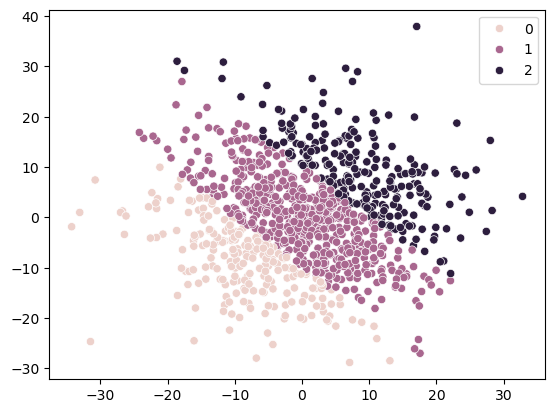

In [21]:
sns.scatterplot(x=X[:,0],y=X[:,1],hue=Y)

In [27]:
params,history,real_grads,approx_grads = train(X, Y, eta=10e-4, epochs=30,batch_size=64,nh=8)

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/15 [00:00<?, ?it/s]

In [31]:
approx_grads[0]['dZ2']

array([[ 0.21642464,  0.31713347, -0.4090058 ,  0.56949383,  0.09689994,
         0.25254952,  0.24612458, -0.77884541,  0.27734885,  0.21705437,
        -0.38467457,  0.27266931,  0.27468136,  0.09705613,  0.42349496,
         0.18838912,  0.48927173,  0.36345712,  0.09686908,  0.21315207,
         0.30056348,  0.27473211,  0.45402391,  0.07516988,  0.28989091,
         0.43129194,  0.0969739 ,  0.30027421,  0.09690974,  0.33199745,
         0.42088638,  0.27235402,  0.27622457,  0.59930081, -0.77946646,
         0.08571614,  0.2642676 ,  0.29878339,  0.34355918,  0.06829709,
         0.19057035,  0.21411617,  0.58421742,  0.46754961,  0.2721189 ,
         0.23027711,  0.22343805,  0.3271113 ,  0.07836877,  0.20771399,
         0.22434233,  0.53286151,  0.09978741,  0.35138993,  0.1789437 ,
         0.20811904,  0.33028792,  0.21643687,  0.23207707, -0.70557323,
         0.47795264,  0.19635873,  0.40458455, -0.40134981],
       [-0.25398908,  0.08302425,  0.37949027, -0.75133913,  0.

In [30]:
real_grads[0]['dZ2']

array([[ 0.21642464,  0.31713347, -0.4090058 ,  0.56949383,  0.09689994,
         0.25254952,  0.24612458, -0.77884541,  0.27734885,  0.21705437,
        -0.38467457,  0.27266931,  0.27468136,  0.09705613,  0.42349496,
         0.18838912,  0.48927173,  0.36345712,  0.09686908,  0.21315207,
         0.30056348,  0.27473211,  0.45402391,  0.07516988,  0.28989091,
         0.43129194,  0.0969739 ,  0.30027421,  0.09690974,  0.33199745,
         0.42088638,  0.27235402,  0.27622457,  0.59930081, -0.77946646,
         0.08571614,  0.2642676 ,  0.29878339,  0.34355918,  0.06829709,
         0.19057035,  0.21411617,  0.58421742,  0.46754961,  0.2721189 ,
         0.23027711,  0.22343805,  0.3271113 ,  0.07836877,  0.20771399,
         0.22434233,  0.53286151,  0.09978741,  0.35138993,  0.1789437 ,
         0.20811904,  0.33028792,  0.21643687,  0.23207707, -0.70557323,
         0.47795264,  0.19635873,  0.40458455, -0.40134981],
       [-0.25398908,  0.08302425,  0.37949027, -0.75133913,  0.

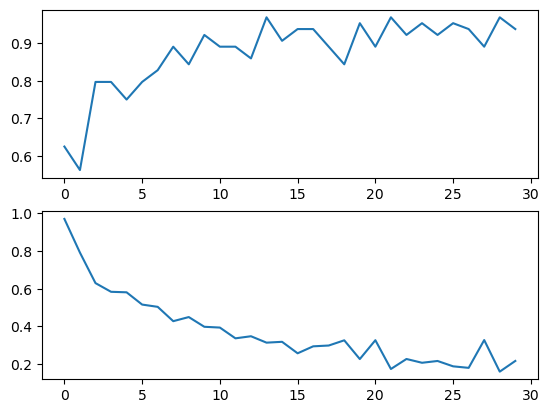

In [17]:
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1)
ax1.plot(np.arange(len(history['accuracy'])),history['accuracy'])
ax2.plot(np.arange(len(history['loss'])),history['loss'])

## Train on mnist handwritten digits

- Dataset link : [https://www.kaggle.com/datasets/oddrationale/mnist-in-csv](link).

### Load the dataset

In [18]:
df = pd.read_csv("./data/mnist_train.csv")

In [19]:
Y = df["label"].values
X = df[df.columns[1:]].values

### Plot the labels distribution

<Axes: ylabel='count'>

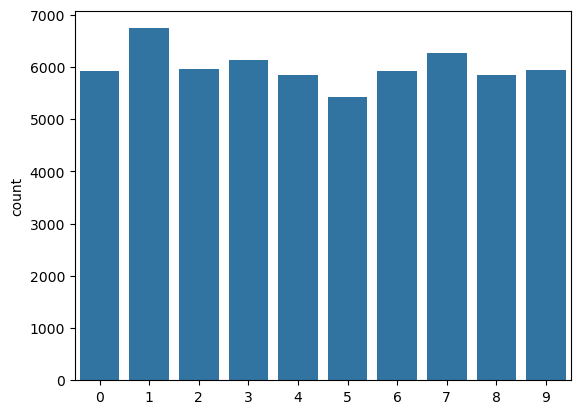

In [20]:
sns.countplot(x=Y)

### Show some images

In [21]:
def plot_random_images(X,Y, nrows=3, ncols=3, real_lables = None):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
    n = nrows * ncols

    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    idx = idx[:n]

    X = X[idx]
    Y = Y[idx]

    if real_lables is not None:
        real_lables = real_lables[idx]
    
    i = 0
    for row in axes:
        for cell in row:
            img = X[i].reshape(28,28)
            cell.imshow(img,cmap="gray")
            if real_lables is None:
                cell.set_title(f"Label = {Y[i]}")
            else:
                cell.set_title(f"Label = {Y[i]} \n Real Label = {real_lables[i]}")
            i += 1

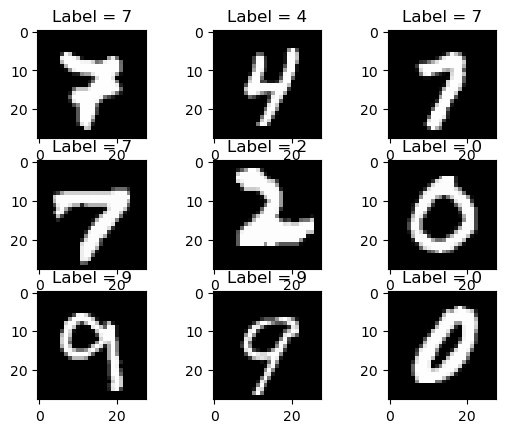

In [22]:
plot_random_images(X,Y)

### Normalization

In [23]:
X = X / 255.0

### Data splitting

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X, Y, test_size=0.2,stratify=Y)

### start the training

In [25]:
params,history = train(
    X_train, 
    y_train, 
    test_set=(X_test,y_test),
    eta=0.01, 
    epochs=50,
    batch_size=128,
    nh=64
)

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

Bar desc:   0%|          | 0/375 [00:00<?, ?it/s]

### Learning graph

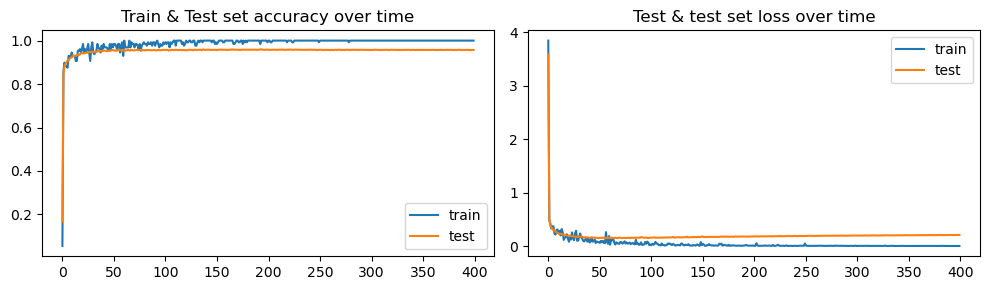

In [36]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)

fig.set_size_inches(10,3)

ax1.plot(np.arange(len(history['accuracy'])),history['accuracy'], label="train")
ax2.plot(np.arange(len(history['loss'])),history['loss'],label="train")

ax1.set_title("Train & Test set accuracy over time")

ax1.plot(np.arange(len(history['test accuracy'])),history['test accuracy'], label='test')
ax2.plot(np.arange(len(history['test loss'])),history['test loss'], label="test")

ax2.set_title("Test & test set loss over time")

ax1.legend()
ax2.legend()

plt.tight_layout()

### Evaluation

In [27]:
y_train_hat = predict(params, X_train)
y_test_hat = predict(params, X_test)

In [28]:
def get_matrics(y, y_hat):
    
    accuracy = accuracy_score(y, y_hat)
    f1 = f1_score(y, y_hat, average="macro")
    precision = precision_score(y, y_hat, average="macro")
    recall = recall_score(y, y_hat, average="macro")

    return pd.Series({
        "accuracy":accuracy,
        "f1_score":f1,
        "precision":precision,
        "recall":recall
    })

In [29]:
train_metrics = get_matrics(y_train, y_train_hat)
test_metrics = get_matrics(y_test, y_test_hat)
metrics = pd.DataFrame(data={
    "train": train_metrics,
    "test":test_metrics
})

In [30]:
metrics

,train,test
accuracy,1.0,0.957167
f1_score,1.0,0.956744
precision,1.0,0.956915
recall,1.0,0.956646


In [31]:
def plot_confusion_matrix(y, y_hat):
    cm = confusion_matrix(y, y_hat)
    ax = sns.heatmap(data=cm, annot=True,cmap='Blues', fmt=',d')
    ax.get_figure().set_size_inches(10,10)
    return ax

Text(0.5, 1.0, 'Train set confusion matrix')

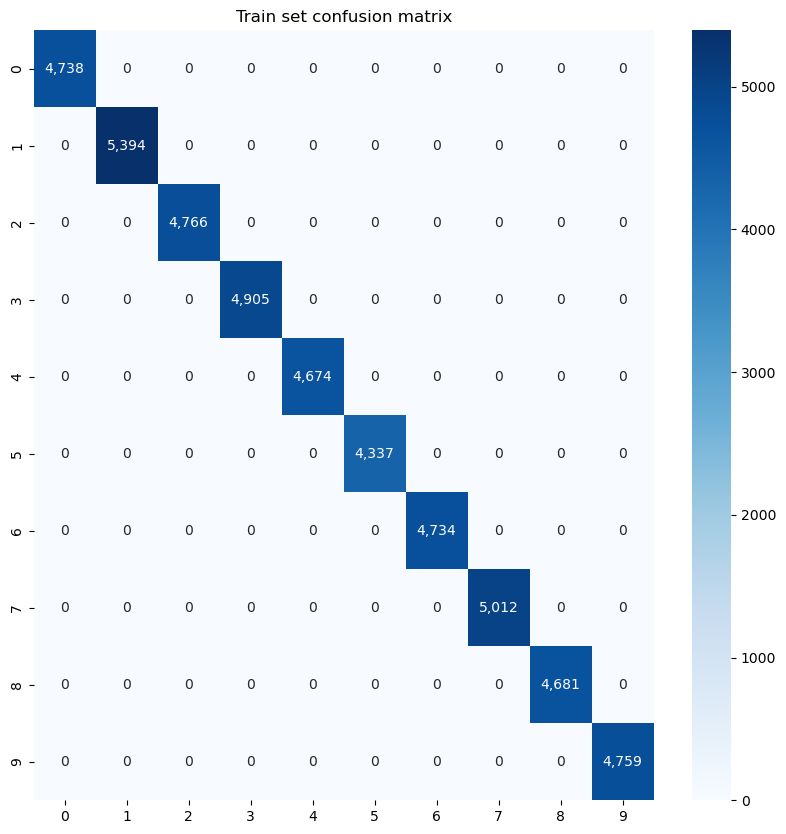

In [32]:
ax = plot_confusion_matrix(y_train, y_train_hat)
ax.set_title("Train set confusion matrix")

Text(0.5, 1.0, 'Test set confusion matrix')

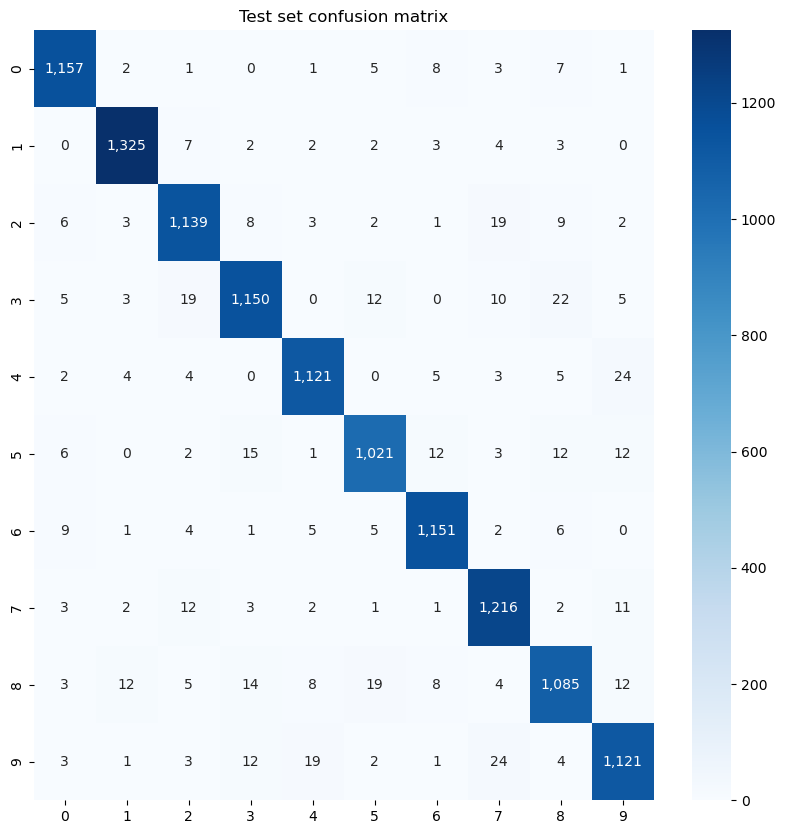

In [33]:
ax = plot_confusion_matrix(y_test, y_test_hat)
ax.set_title("Test set confusion matrix")

### Error analysis
- show miss-classified data points

In [34]:
X_test_ = X_test[y_test_hat != y_test]
y_test_ = y_test[y_test_hat != y_test]
y_test_hat_ = y_test_hat[y_test_hat != y_test]

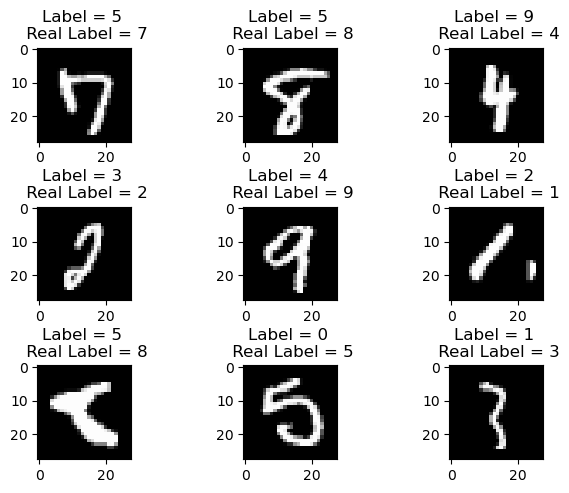

In [38]:
plot_random_images(X_test_,y_test_hat_,real_lables=y_test_)
plt.tight_layout(pad=0.25)